In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#importing dataset
df = pd.read_csv('../input/pima-indians-diabetes-database/diabetes.csv')
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [4]:
df_nomiss = df[(df['Glucose']!=0) & (df['BloodPressure']!=0) & (df['SkinThickness']!=0)  & (df['Insulin']!=0) & (df['BMI']!=0)]
df_miss  = df[(df['Glucose']==0) | (df['BloodPressure']==0) | (df['SkinThickness']==0)  | (df['Insulin']==0) | (df['BMI']==0)]

In [5]:
X_nomiss=df_nomiss.drop('Outcome',axis=1)
y_nomiss=df_nomiss['Outcome']

<AxesSubplot:xlabel='Outcome', ylabel='count'>

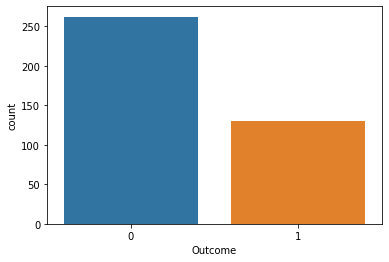

In [6]:
sns.countplot(x="Outcome", data=df_nomiss)

In [7]:
from sklearn.model_selection import train_test_split
X_train_nomiss,X_test_nomiss,y_train_nomiss,y_test_nomiss =  train_test_split(X_nomiss,y_nomiss,test_size=0.20, random_state=7,stratify=y_nomiss)

In [8]:
df_train_nomiss = pd.concat([X_train_nomiss,y_train_nomiss], axis=1)

In [9]:
df_train = pd.concat([df_train_nomiss,df_miss], axis=0)

In [10]:
ms_col = ['Glucose','BloodPressure','SkinThickness','Insulin','BMI']
for i in ms_col:
    df_train.loc[((df_train['Outcome'] == 0) & (df_train[i] == 0)), i] =  df_train[(df_train['Outcome']==0) & (df_train[i]!=0)][i].median()
    df_train.loc[((df_train['Outcome'] == 1) & (df_train[i] == 0)), i] =  df_train[(df_train['Outcome']==1) & (df_train[i]!=0)][i].median()

In [11]:
X=df_train.drop('Outcome',axis=1)
y=df_train['Outcome']

In [12]:
from sklearn.model_selection import train_test_split
X_train_1,X_test_1,y_train_1,y_test_1 =  train_test_split(X,y,test_size=0.20, random_state=7,stratify=y)

In [13]:
X_test = pd.concat([X_test_1,X_test_nomiss], axis=0)
y_test = pd.concat([y_test_1,y_test_nomiss], axis=0)

In [14]:
from sklearn.preprocessing import StandardScaler
scaling_x=StandardScaler()
X_train_1=scaling_x.fit_transform(X_train_1)
X_test=scaling_x.fit_transform(X_test)
X_test_1=scaling_x.fit_transform(X_test_1)
X_test_nomiss=scaling_x.fit_transform(X_test_nomiss)

In [15]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import metrics  
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_score

In [16]:
xgb1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=100,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27,
 use_label_encoder=False,  
 eval_metric='auc')

xgb1.fit(X_train_1, 
          y_train_1,
          eval_metric="auc")

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8,
              enable_categorical=False, eval_metric='auc', gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, nthread=4, num_parallel_tree=1,
              predictor='auto', random_state=27, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, seed=27, subsample=0.8, tree_method='exact',
              use_label_encoder=False, ...)

In [17]:
print("\nModel Report")
y_preds = xgb1.predict(X_test)
y_pred_proba = xgb1.predict_proba(X_test)[:,1]

y_preds1 = xgb1.predict(X_train_1)
y_pred_proba1 = xgb1.predict_proba(X_train_1)[:,1]

print('Accuracy (Train):', round(metrics.accuracy_score(y_train_1, y_preds1) * 100,2),'%')
print('Accuracy (Test):', round(metrics.accuracy_score(y_test, y_preds) * 100,2),'%')
print('AUC Score (Train):', round(metrics.roc_auc_score(y_train_1, y_pred_proba1) * 100,2),'%')
print('AUC Score (Test):', round(metrics.roc_auc_score(y_test, y_pred_proba) * 100,2),'%')


Model Report
Accuracy (Train): 99.82 %
Accuracy (Test): 81.57 %
AUC Score (Train): 100.0 %
AUC Score (Test): 89.2 %


To start with, let’s set wider ranges and then we will perform another iteration for smaller ranges.

In [18]:
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}

gsearch1 = GridSearchCV(estimator=XGBClassifier(learning_rate =0.1,
                                                n_estimators=100,
                                                #max_depth=5,
                                                #min_child_weight=1,
                                                gamma=0,
                                                subsample=0.8,
                                                colsample_bytree=0.8,
                                                objective= 'binary:logistic',
                                                nthread=4,
                                                scale_pos_weight=1,
                                                seed=27,
                                                use_label_encoder=False,  
                                                eval_metric='auc'),
                        param_grid = param_test1, 
                        scoring='roc_auc',
                        n_jobs=4,
                        cv=5)
eval_set = [(X_test, y_test)]

gsearch1.fit(X_train_1, y_train_1,early_stopping_rounds=5,eval_set=eval_set)
print("Tuned Paramerers ==> ",gsearch1.best_params_)
print("Best Score ==> ",gsearch1.best_score_)
print("Accuracy on Train set ==> ", gsearch1.score(X_train_1,y_train_1))
print("Accuracy on Test set ==> ", gsearch1.score(X_test,y_test))

[0]	validation_0-auc:0.77462
[1]	validation_0-auc:0.85050
[2]	validation_0-auc:0.87516
[3]	validation_0-auc:0.88844
[4]	validation_0-auc:0.88717
[5]	validation_0-auc:0.89430
[6]	validation_0-auc:0.90763
[7]	validation_0-auc:0.90838
[8]	validation_0-auc:0.90380
[9]	validation_0-auc:0.90550
[10]	validation_0-auc:0.90333
[11]	validation_0-auc:0.90947
[12]	validation_0-auc:0.90805
[13]	validation_0-auc:0.90720
[14]	validation_0-auc:0.90621
[15]	validation_0-auc:0.90583
[16]	validation_0-auc:0.90479
[0]	validation_0-auc:0.82659
[1]	validation_0-auc:0.89742
[2]	validation_0-auc:0.91060
[3]	validation_0-auc:0.91575
[4]	validation_0-auc:0.91750
[5]	validation_0-auc:0.91774
[6]	validation_0-auc:0.91911
[7]	validation_0-auc:0.91868
[8]	validation_0-auc:0.91741
[9]	validation_0-auc:0.91462
[10]	validation_0-auc:0.91259
[11]	validation_0-auc:0.91169
[0]	validation_0-auc:0.75321
[1]	validation_0-auc:0.86085
[2]	validation_0-auc:0.88584
[3]	validation_0-auc:0.89104
[4]	validation_0-auc:0.88783
[5]	v

In [19]:
param_test2 = {
 'max_depth':[4,5,6],
 'min_child_weight':[2,3,4,5,6,7,8,9]
}


gsearch2 = GridSearchCV(estimator=XGBClassifier(learning_rate =0.1,
                                                n_estimators=100,
                                                #max_depth=5,
                                                #min_child_weight=1,
                                                gamma=0,
                                                subsample=0.8,
                                                colsample_bytree=0.8,
                                                objective= 'binary:logistic',
                                                nthread=4,
                                                scale_pos_weight=1,
                                                seed=27,
                                                use_label_encoder=False,  
                                                eval_metric='auc'),
                        param_grid = param_test2, 
                        scoring='roc_auc',
                        n_jobs=4,
                        cv=5)
eval_set = [(X_test, y_test)]

gsearch2.fit(X_train_1, y_train_1,early_stopping_rounds=5,eval_set=eval_set)
print("Tuned Paramerers ==> ",gsearch2.best_params_)
print("Best Score ==> ",gsearch2.best_score_)
print("Accuracy on Train set ==> ", gsearch2.score(X_train_1,y_train_1))
print("Accuracy on Test set ==> ", gsearch2.score(X_test,y_test))

[0]	validation_0-auc:0.79924
[0]	validation_0-auc:0.79243
[1]	validation_0-auc:0.88405
[0]	validation_0-auc:0.83222
[2]	validation_0-auc:0.90319
[1]	validation_0-auc:0.84681
[3]	validation_0-auc:0.90890
[4]	validation_0-auc:0.89884
[2]	validation_0-auc:0.87682
[1]	validation_0-auc:0.89189
[5]	validation_0-auc:0.90167
[3]	validation_0-auc:0.89000
[6]	validation_0-auc:0.90843
[2]	validation_0-auc:0.89794
[4]	validation_0-auc:0.89241
[7]	validation_0-auc:0.90796
[5]	validation_0-auc:0.89605
[3]	validation_0-auc:0.89326
[8]	validation_0-auc:0.90333
[6]	validation_0-auc:0.90101
[4]	validation_0-auc:0.90163
[5]	validation_0-auc:0.89676
[0]	validation_0-auc:0.82413
[1]	validation_0-auc:0.87219
[7]	validation_0-auc:0.89922
[2]	validation_0-auc:0.88249
[3]	validation_0-auc:0.88665
[8]	validation_0-auc:0.89855
[4]	validation_0-auc:0.88211
[9]	validation_0-auc:0.89340
[0]	validation_0-auc:0.82640
[10]	validation_0-auc:0.89000
[5]	validation_0-auc:0.88225
[6]	validation_0-auc:0.89822
[1]	validatio

In [20]:
param_test3 = {
 'n_estimators':range(100,2000,25)
}

gsearch3 = GridSearchCV(estimator=XGBClassifier(learning_rate =0.1,
                                                #n_estimators=100,
                                                max_depth=5,
                                                min_child_weight=6,
                                                gamma=0,
                                                subsample=0.8,
                                                colsample_bytree=0.8,
                                                objective= 'binary:logistic',
                                                nthread=4,
                                                scale_pos_weight=1,
                                                seed=27,
                                                use_label_encoder=False,  
                                                eval_metric='auc'),
                        param_grid = param_test3, 
                        scoring='roc_auc',
                        n_jobs=4,
                        cv=5)
eval_set = [(X_test, y_test)]

gsearch3.fit(X_train_1, y_train_1,early_stopping_rounds=5,eval_set=eval_set)
print("Tuned Paramerers ==> ",gsearch3.best_params_)
print("Best Score ==> ",gsearch3.best_score_)
print("Accuracy on Train set ==> ", gsearch3.score(X_train_1,y_train_1))
print("Accuracy on Test set ==> ", gsearch3.score(X_test,y_test))

[0]	validation_0-auc:0.79271
[1]	validation_0-auc:0.87918
[2]	validation_0-auc:0.89624
[0]	validation_0-auc:0.83146
[0]	validation_0-auc:0.77282
[0]	validation_0-auc:0.75723
[3]	validation_0-auc:0.89492
[1]	validation_0-auc:0.87299
[1]	validation_0-auc:0.85839
[2]	validation_0-auc:0.87909
[1]	validation_0-auc:0.83996
[2]	validation_0-auc:0.88296
[3]	validation_0-auc:0.88287
[3]	validation_0-auc:0.88301
[4]	validation_0-auc:0.88679
[4]	validation_0-auc:0.87880
[4]	validation_0-auc:0.90592
[5]	validation_0-auc:0.88755
[5]	validation_0-auc:0.88712
[6]	validation_0-auc:0.88877
[6]	validation_0-auc:0.88721
[7]	validation_0-auc:0.88230
[7]	validation_0-auc:0.88329
[8]	validation_0-auc:0.88424
[8]	validation_0-auc:0.88476
[9]	validation_0-auc:0.89024
[9]	validation_0-auc:0.88996
[2]	validation_0-auc:0.87602
[5]	validation_0-auc:0.90715
[10]	validation_0-auc:0.88929
[10]	validation_0-auc:0.89099
[3]	validation_0-auc:0.88778
[11]	validation_0-auc:0.88646
[6]	validation_0-auc:0.90748
[12]	valida

In [21]:
param_test4 = {
 'gamma':[i/10.0 for i in range(0,5)],
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch4 = GridSearchCV(estimator=XGBClassifier(learning_rate =0.1,
                                                n_estimators=100,
                                                max_depth=5,
                                                min_child_weight=6,
                                                #gamma=0,
                                                #subsample=0.8,
                                                #colsample_bytree=0.8,
                                                objective= 'binary:logistic',
                                                nthread=4,
                                                scale_pos_weight=1,
                                                seed=27,
                                                use_label_encoder=False,  
                                                eval_metric='auc'),
                        param_grid = param_test4, 
                        scoring='roc_auc',
                        n_jobs=4,
                        cv=5)
eval_set = [(X_test, y_test)]
gsearch4.fit(X_train_1, y_train_1,early_stopping_rounds=5,eval_set=eval_set)
print("Tuned Paramerers ==> ",gsearch4.best_params_)
print("Best Score ==> ",gsearch4.best_score_)
print("Accuracy on Train set ==> ", gsearch4.score(X_train_1,y_train_1))
print("Accuracy on Test set ==> ", gsearch4.score(X_test,y_test))

[0]	validation_0-auc:0.72042
[1]	validation_0-auc:0.82418
[2]	validation_0-auc:0.86137
[3]	validation_0-auc:0.85485
[4]	validation_0-auc:0.85891
[5]	validation_0-auc:0.88599
[0]	validation_0-auc:0.72940
[0]	validation_0-auc:0.68243
[0]	validation_0-auc:0.73119
[6]	validation_0-auc:0.87871
[1]	validation_0-auc:0.81497
[7]	validation_0-auc:0.89099
[1]	validation_0-auc:0.82919
[1]	validation_0-auc:0.82168
[8]	validation_0-auc:0.88967
[2]	validation_0-auc:0.86255
[9]	validation_0-auc:0.89194
[3]	validation_0-auc:0.85858
[2]	validation_0-auc:0.85258
[10]	validation_0-auc:0.89770
[4]	validation_0-auc:0.86194
[2]	validation_0-auc:0.85003
[3]	validation_0-auc:0.86331
[11]	validation_0-auc:0.89808
[5]	validation_0-auc:0.87280
[3]	validation_0-auc:0.86756
[4]	validation_0-auc:0.86189
[6]	validation_0-auc:0.88877
[12]	validation_0-auc:0.89685
[7]	validation_0-auc:0.88755
[5]	validation_0-auc:0.86723
[4]	validation_0-auc:0.87743
[8]	validation_0-auc:0.88584
[13]	validation_0-auc:0.89855
[6]	valida

In [22]:
param_test5 = {
 'gamma':[i/100.0 for i in range(1,20,5)],
 'subsample':[i/100.0 for i in range(45,100,5)],
 'colsample_bytree':[i/100.0 for i in range(45,100,5)]
}
gsearch5 = GridSearchCV(estimator=XGBClassifier(learning_rate =0.1,
                                                n_estimators=100,
                                                max_depth=5,
                                                min_child_weight=6,
                                                #gamma=0,
                                                #subsample=0.8,
                                                #colsample_bytree=0.8,
                                                objective= 'binary:logistic',
                                                nthread=4,
                                                scale_pos_weight=1,
                                                seed=27,
                                                use_label_encoder=False,  
                                                eval_metric='auc'),
                        param_grid = param_test5, 
                        scoring='roc_auc',
                        n_jobs=4,
                        cv=5)
eval_set = [(X_test, y_test)]
gsearch5.fit(X_train_1, y_train_1,early_stopping_rounds=5,eval_set=eval_set)
print("Tuned Paramerers ==> ",gsearch5.best_params_)
print("Best Score ==> ",gsearch5.best_score_)
print("Accuracy on Train set ==> ", gsearch5.score(X_train_1,y_train_1))
print("Accuracy on Test set ==> ", gsearch5.score(X_test,y_test))

[0]	validation_0-auc:0.74343
[0]	validation_0-auc:0.71966
[1]	validation_0-auc:0.82669
[1]	validation_0-auc:0.83392
[2]	validation_0-auc:0.86813
[2]	validation_0-auc:0.86477
[3]	validation_0-auc:0.86893
[0]	validation_0-auc:0.73171
[0]	validation_0-auc:0.75307
[1]	validation_0-auc:0.82593
[3]	validation_0-auc:0.88324
[2]	validation_0-auc:0.86846
[4]	validation_0-auc:0.86652
[3]	validation_0-auc:0.87138
[4]	validation_0-auc:0.87521
[1]	validation_0-auc:0.85934
[4]	validation_0-auc:0.86770
[5]	validation_0-auc:0.88594
[2]	validation_0-auc:0.88580
[5]	validation_0-auc:0.88164
[3]	validation_0-auc:0.88514
[6]	validation_0-auc:0.87767
[4]	validation_0-auc:0.88263
[7]	validation_0-auc:0.87862
[5]	validation_0-auc:0.87261
[5]	validation_0-auc:0.89260
[6]	validation_0-auc:0.88395
[8]	validation_0-auc:0.87365
[6]	validation_0-auc:0.88618
[9]	validation_0-auc:0.87847
[7]	validation_0-auc:0.89194
[6]	validation_0-auc:0.86444
[7]	validation_0-auc:0.89515
[8]	validation_0-auc:0.89274
[7]	validation

In [23]:
param_test6 = {
 'nthread':range(1,10,1),
}
gsearch6 = GridSearchCV(estimator=XGBClassifier(learning_rate =0.1,
                                                n_estimators=100,
                                                max_depth=5,
                                                min_child_weight=6,
                                                gamma=0.06,
                                                subsample=0.75,
                                                colsample_bytree=0.8,
                                                objective= 'binary:logistic',
                                                #nthread=4,
                                                scale_pos_weight=1,
                                                seed=27,
                                                use_label_encoder=False,  
                                                eval_metric='auc'),
                        param_grid = param_test6, 
                        scoring='roc_auc',
                        n_jobs=4,
                        cv=5)
eval_set = [(X_test, y_test)]
gsearch6.fit(X_train_1, y_train_1,early_stopping_rounds=5,eval_set=eval_set)
print("Tuned Paramerers ==> ",gsearch6.best_params_)
print("Best Score ==> ",gsearch6.best_score_)
print("Accuracy on Train set ==> ", gsearch6.score(X_train_1,y_train_1))
print("Accuracy on Test set ==> ", gsearch6.score(X_test,y_test))

[0]	validation_0-auc:0.78936
[1]	validation_0-auc:0.87583
[2]	validation_0-auc:0.90252
[3]	validation_0-auc:0.90517
[4]	validation_0-auc:0.90834
[5]	validation_0-auc:0.91126
[6]	validation_0-auc:0.91164
[0]	validation_0-auc:0.77372
[7]	validation_0-auc:0.91004
[8]	validation_0-auc:0.90791
[9]	validation_0-auc:0.90725
[1]	validation_0-auc:0.85480
[10]	validation_0-auc:0.90460
[2]	validation_0-auc:0.87857
[11]	validation_0-auc:0.90422
[3]	validation_0-auc:0.88150
[4]	validation_0-auc:0.88509
[5]	validation_0-auc:0.88769
[0]	validation_0-auc:0.80283
[1]	validation_0-auc:0.87365
[2]	validation_0-auc:0.88159
[3]	validation_0-auc:0.88372
[6]	validation_0-auc:0.89402
[4]	validation_0-auc:0.88291
[7]	validation_0-auc:0.89369
[5]	validation_0-auc:0.89062
[8]	validation_0-auc:0.89388
[6]	validation_0-auc:0.89770
[9]	validation_0-auc:0.89397
[7]	validation_0-auc:0.89260
[10]	validation_0-auc:0.89317
[8]	validation_0-auc:0.89681
[9]	validation_0-auc:0.89931
[10]	validation_0-auc:0.89898
[11]	valid

In [24]:
param_test7 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}
gsearch7 = GridSearchCV(estimator=XGBClassifier(learning_rate =0.1,
                                                n_estimators=1000,
                                                max_depth=5,
                                                min_child_weight=6,
                                                gamma=0.06,
                                                subsample=0.75,
                                                colsample_bytree=0.8,
                                                #reg_alpha=,
                                                objective= 'binary:logistic',
                                                nthread=1,
                                                scale_pos_weight=1,
                                                seed=27,
                                                use_label_encoder=False,  
                                                eval_metric='auc'),
                        param_grid = param_test7, 
                        scoring='roc_auc',
                        n_jobs=4,
                        cv=5)
eval_set = [(X_test, y_test)]
gsearch7.fit(X_train_1, y_train_1,early_stopping_rounds=5,eval_set=eval_set)
print("Tuned Paramerers ==> ",gsearch7.best_params_)
print("Best Score ==> ",gsearch7.best_score_)
print("Accuracy on Train set ==> ", gsearch7.score(X_train_1,y_train_1))
print("Accuracy on Test set ==> ", gsearch7.score(X_test,y_test))

[0]	validation_0-auc:0.78936
[0]	validation_0-auc:0.77372
[0]	validation_0-auc:0.80283
[1]	validation_0-auc:0.87365
[1]	validation_0-auc:0.87583
[1]	validation_0-auc:0.85480
[2]	validation_0-auc:0.88159
[2]	validation_0-auc:0.87857
[3]	validation_0-auc:0.88150
[3]	validation_0-auc:0.88372
[4]	validation_0-auc:0.88509
[5]	validation_0-auc:0.88769
[4]	validation_0-auc:0.88291
[6]	validation_0-auc:0.89402
[5]	validation_0-auc:0.89062
[2]	validation_0-auc:0.90252
[6]	validation_0-auc:0.89770
[7]	validation_0-auc:0.89260
[3]	validation_0-auc:0.90517
[8]	validation_0-auc:0.89681
[9]	validation_0-auc:0.89931
[4]	validation_0-auc:0.90834
[5]	validation_0-auc:0.91126
[10]	validation_0-auc:0.89898
[11]	validation_0-auc:0.89851
[12]	validation_0-auc:0.89709
[13]	validation_0-auc:0.89633
[0]	validation_0-auc:0.80420
[1]	validation_0-auc:0.87157
[2]	validation_0-auc:0.87455
[3]	validation_0-auc:0.88962
[6]	validation_0-auc:0.91164
[7]	validation_0-auc:0.91004
[8]	validation_0-auc:0.90791
[4]	valida

In [25]:
param_test8 = {
 'learning_rate':[i/100.0 for i in range(1,10)]
}
gsearch8 = GridSearchCV(estimator=XGBClassifier(#learning_rate =0.1,
                                                n_estimators=100,
                                                max_depth=5,
                                                min_child_weight=6,
                                                gamma=0.06,
                                                subsample=0.75,
                                                colsample_bytree=0.8,
                                                reg_alpha= 0.1,
                                                objective= 'binary:logistic',
                                                nthread=4,
                                                scale_pos_weight=1,
                                                seed=27,
                                                use_label_encoder=False,  
                                                eval_metric='auc'),
                        param_grid = param_test8, 
                        scoring='roc_auc',
                        n_jobs=4,
                        cv=5)
eval_set = [(X_test, y_test)]
gsearch8.fit(X_train_1, y_train_1,early_stopping_rounds=5,eval_set=eval_set)
print("Tuned Paramerers ==> ",gsearch8.best_params_)
print("Best Score ==> ",gsearch8.best_score_)
print("Accuracy on Train set ==> ", gsearch8.score(X_train_1,y_train_1))
print("Accuracy on Test set ==> ", gsearch8.score(X_test,y_test))

[0]	validation_0-auc:0.80420
[0]	validation_0-auc:0.78936
[1]	validation_0-auc:0.87304
[0]	validation_0-auc:0.80283
[0]	validation_0-auc:0.77372
[1]	validation_0-auc:0.87309
[2]	validation_0-auc:0.88169
[2]	validation_0-auc:0.87384
[1]	validation_0-auc:0.87687
[1]	validation_0-auc:0.84582
[3]	validation_0-auc:0.88254
[3]	validation_0-auc:0.87469
[2]	validation_0-auc:0.90177
[4]	validation_0-auc:0.88041
[4]	validation_0-auc:0.87465
[2]	validation_0-auc:0.88055
[5]	validation_0-auc:0.88324
[5]	validation_0-auc:0.87554
[3]	validation_0-auc:0.89737
[6]	validation_0-auc:0.88698
[6]	validation_0-auc:0.86992
[7]	validation_0-auc:0.88868
[3]	validation_0-auc:0.87980
[7]	validation_0-auc:0.86368
[8]	validation_0-auc:0.88556
[8]	validation_0-auc:0.87909
[4]	validation_0-auc:0.90314
[4]	validation_0-auc:0.88041
[9]	validation_0-auc:0.88679
[9]	validation_0-auc:0.88490
[10]	validation_0-auc:0.88424
[10]	validation_0-auc:0.88877
[5]	validation_0-auc:0.90947
[11]	validation_0-auc:0.88967
[5]	validat

In [26]:
param_test9 = {
 'learning_rate':[i/100.0 for i in range(1,8)]
}
gsearch9 = GridSearchCV(estimator=XGBClassifier(#learning_rate =0.1,
                                                n_estimators=100,
                                                max_depth=5,
                                                min_child_weight=6,
                                                gamma=0.06,
                                                subsample=0.75,
                                                colsample_bytree=0.8,
                                                reg_alpha= 0.1,
                                                objective= 'binary:logistic',
                                                nthread=4,
                                                scale_pos_weight=1,
                                                seed=27,
                                                use_label_encoder=False,  
                                                eval_metric='auc'),
                        param_grid = param_test9, 
                        scoring='roc_auc',
                        n_jobs=4,
                        cv=5)
eval_set = [(X_test, y_test)]
gsearch9.fit(X_train_1, y_train_1,early_stopping_rounds=5,eval_set=eval_set)
print("Tuned Paramerers ==> ",gsearch9.best_params_)
print("Best Score ==> ",gsearch9.best_score_)
print("Accuracy on Train set ==> ", gsearch9.score(X_train_1,y_train_1))
print("Accuracy on Test set ==> ", gsearch9.score(X_test,y_test))

[0]	validation_0-auc:0.78936
[0]	validation_0-auc:0.77372
[1]	validation_0-auc:0.87687
[1]	validation_0-auc:0.84582
[0]	validation_0-auc:0.80283
[2]	validation_0-auc:0.88055
[2]	validation_0-auc:0.90177
[3]	validation_0-auc:0.87980
[1]	validation_0-auc:0.87309
[3]	validation_0-auc:0.89737
[2]	validation_0-auc:0.88169
[4]	validation_0-auc:0.88041
[4]	validation_0-auc:0.90314
[5]	validation_0-auc:0.88277
[5]	validation_0-auc:0.90947
[3]	validation_0-auc:0.88254
[6]	validation_0-auc:0.88377
[4]	validation_0-auc:0.88041
[6]	validation_0-auc:0.90852
[7]	validation_0-auc:0.88589
[7]	validation_0-auc:0.90682
[5]	validation_0-auc:0.88324
[8]	validation_0-auc:0.88386
[8]	validation_0-auc:0.90597
[9]	validation_0-auc:0.88740
[6]	validation_0-auc:0.88698
[9]	validation_0-auc:0.90541
[10]	validation_0-auc:0.88391
[7]	validation_0-auc:0.88868
[11]	validation_0-auc:0.88821
[12]	validation_0-auc:0.89000
[0]	validation_0-auc:0.80420
[13]	validation_0-auc:0.88783
[1]	validation_0-auc:0.87304
[14]	valid

In [27]:
param_test10 = {
 'scale_pos_weight':range(1,8,1)
}
gsearch10 = GridSearchCV(estimator=XGBClassifier(learning_rate =0.06,
                                                n_estimators=100,
                                                max_depth=5,
                                                min_child_weight=6,
                                                gamma=0.06,
                                                subsample=0.75,
                                                colsample_bytree=0.8,
                                                reg_alpha= 0.1,
                                                objective= 'binary:logistic',
                                                nthread=4,
                                                scale_pos_weight=1,
                                                seed=27,
                                                use_label_encoder=False,  
                                                eval_metric='auc'),
                        param_grid = param_test10, 
                        scoring='roc_auc',
                        n_jobs=4,
                        cv=5)
eval_set = [(X_test, y_test)]
gsearch10.fit(X_train_1, y_train_1,early_stopping_rounds=5,eval_set=eval_set)
print("Tuned Paramerers ==> ",gsearch10.best_params_)
print("Best Score ==> ",gsearch10.best_score_)
print("Accuracy on Train set ==> ", gsearch10.score(X_train_1,y_train_1))
print("Accuracy on Test set ==> ", gsearch10.score(X_test,y_test))

[0]	validation_0-auc:0.80283
[0]	validation_0-auc:0.80420
[0]	validation_0-auc:0.77372
[1]	validation_0-auc:0.87243
[1]	validation_0-auc:0.85782
[0]	validation_0-auc:0.78936
[1]	validation_0-auc:0.87384
[2]	validation_0-auc:0.87455
[2]	validation_0-auc:0.87961
[1]	validation_0-auc:0.87668
[2]	validation_0-auc:0.88169
[3]	validation_0-auc:0.87502
[3]	validation_0-auc:0.88372
[3]	validation_0-auc:0.88121
[2]	validation_0-auc:0.90337
[4]	validation_0-auc:0.87866
[4]	validation_0-auc:0.88301
[4]	validation_0-auc:0.88088
[3]	validation_0-auc:0.89992
[5]	validation_0-auc:0.88466
[5]	validation_0-auc:0.88381
[5]	validation_0-auc:0.88410
[6]	validation_0-auc:0.88504
[4]	validation_0-auc:0.90399
[6]	validation_0-auc:0.88693
[6]	validation_0-auc:0.88495
[7]	validation_0-auc:0.87318
[5]	validation_0-auc:0.91032
[7]	validation_0-auc:0.88712
[7]	validation_0-auc:0.88811
[8]	validation_0-auc:0.87970
[8]	validation_0-auc:0.88717
[6]	validation_0-auc:0.90937
[8]	validation_0-auc:0.88882
[9]	validation

In [28]:
xgb =XGBClassifier(learning_rate =0.1,
                   n_estimators=100,
                   max_depth=5,
                   min_child_weight=6,
                   gamma=0.06,
                   subsample=0.75,
                   colsample_bytree=0.8,
                   objective= 'binary:logistic',
                   nthread=4,
                   scale_pos_weight=1,
                   seed=27,
                   use_label_encoder=False,  
                   eval_metric='auc')
xgb.fit(X_train_1, y_train_1,early_stopping_rounds=5,eval_set=eval_set)

print("\nModel Report")
y_predsx = xgb.predict(X_test)
y_predx_proba = xgb.predict_proba(X_test)[:,1]

y_predsx1 = xgb.predict(X_train_1)
y_predx_proba1 = xgb.predict_proba(X_train_1)[:,1]

print('Accuracy (Train):', round(metrics.accuracy_score(y_train_1, y_predsx1) * 100,2),'%')
print('Accuracy (Test):', round(metrics.accuracy_score(y_test, y_predsx) * 100,2),'%')
print('AUC Score (Train):', round(metrics.roc_auc_score(y_train_1, y_predx_proba1) * 100,2),'%')
print('AUC Score (Test):', round(metrics.roc_auc_score(y_test, y_predx_proba) * 100,2),'%')

[0]	validation_0-auc:0.80188
[1]	validation_0-auc:0.85679
[2]	validation_0-auc:0.86406
[3]	validation_0-auc:0.87743
[4]	validation_0-auc:0.88173
[5]	validation_0-auc:0.88731
[6]	validation_0-auc:0.88216
[7]	validation_0-auc:0.87989
[8]	validation_0-auc:0.88173
[9]	validation_0-auc:0.88117
[10]	validation_0-auc:0.88589

Model Report
Accuracy (Train): 89.29 %
Accuracy (Test): 82.03 %
AUC Score (Train): 97.05 %
AUC Score (Test): 88.73 %
